# **1. Load the dataset**

In [ ]:
# Put your dataset CelebA in your drive then execute this code to get access on your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the CelebA
! unzip /content/drive/MyDrive/IA/celebA.zip -d celebrities

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: celebrities/Dataset/Validation/Male/189674.jpg  
  inflating: celebrities/Dataset/Validation/Male/189675.jpg  
  inflating: celebrities/Dataset/Validation/Male/189676.jpg  
  inflating: celebrities/Dataset/Validation/Male/189679.jpg  
  inflating: celebrities/Dataset/Validation/Male/189681.jpg  
  inflating: celebrities/Dataset/Validation/Male/189684.jpg  
  inflating: celebrities/Dataset/Validation/Male/189688.jpg  
  inflating: celebrities/Dataset/Validation/Male/189689.jpg  
  inflating: celebrities/Dataset/Validation/Male/189691.jpg  
  inflating: celebrities/Dataset/Validation/Male/189692.jpg  
  inflating: celebrities/Dataset/Validation/Male/189693.jpg  
  inflating: celebrities/Dataset/Validation/Male/189694.jpg  
  inflating: celebrities/Dataset/Validation/Male/189695.jpg  
  inflating: celebrities/Dataset/Validation/Male/189696.jpg  
  inflating: celebrities/Dataset/Validation/Male/18969

In [ ]:
# We can use the function 'image_dataset_from_directory' on keras.preprocessing to load our unziped dataset
from tensorflow.keras.utils import image_dataset_from_directory

# Load train dataset
train_ds = image_dataset_from_directory(
    directory="celebrities/Dataset/Train",
    class_names=["Female", "Male"],
    batch_size=None
)

# Load test dataset
test_ds = image_dataset_from_directory(
    "celebrities/Dataset/Test",
    class_names=["Female", "Male"],
    batch_size=None
)

# Load validation dataset
val_ds = image_dataset_from_directory(
    "celebrities/Dataset/Validation",
    class_names=["Female", "Male"],
    batch_size=None,
)

Found 160000 files belonging to 2 classes.
Found 20001 files belonging to 2 classes.
Found 22598 files belonging to 2 classes.


In [ ]:
# Create a dictionnary for labels
labels = {
    0: "Female",
    1: "Male"
}

In [ ]:
# Show train dataset
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [ ]:
# Understand iterator in python
data = [1, 7, 3]
iterator = iter(data)
print(next(iterator))
print(next(iterator))
print(next(iterator))

1
7
3


In [ ]:
# Create an iterator to get images
train_iter = iter(train_ds)

In [ ]:
# Show the first image in the training dataset
train_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [ ]:
# Show the output of the first element in the training dataset
image, label = next(train_iter)
print("Shape of the first image in the training dataset: ", image.shape)
print("Class of the first image in the training dataset: ", label)


Shape of the first image in the training dataset:  (256, 256, 3)
Class of the first image in the training dataset:  tf.Tensor(0, shape=(), dtype=int32)


# **2. Visualization**

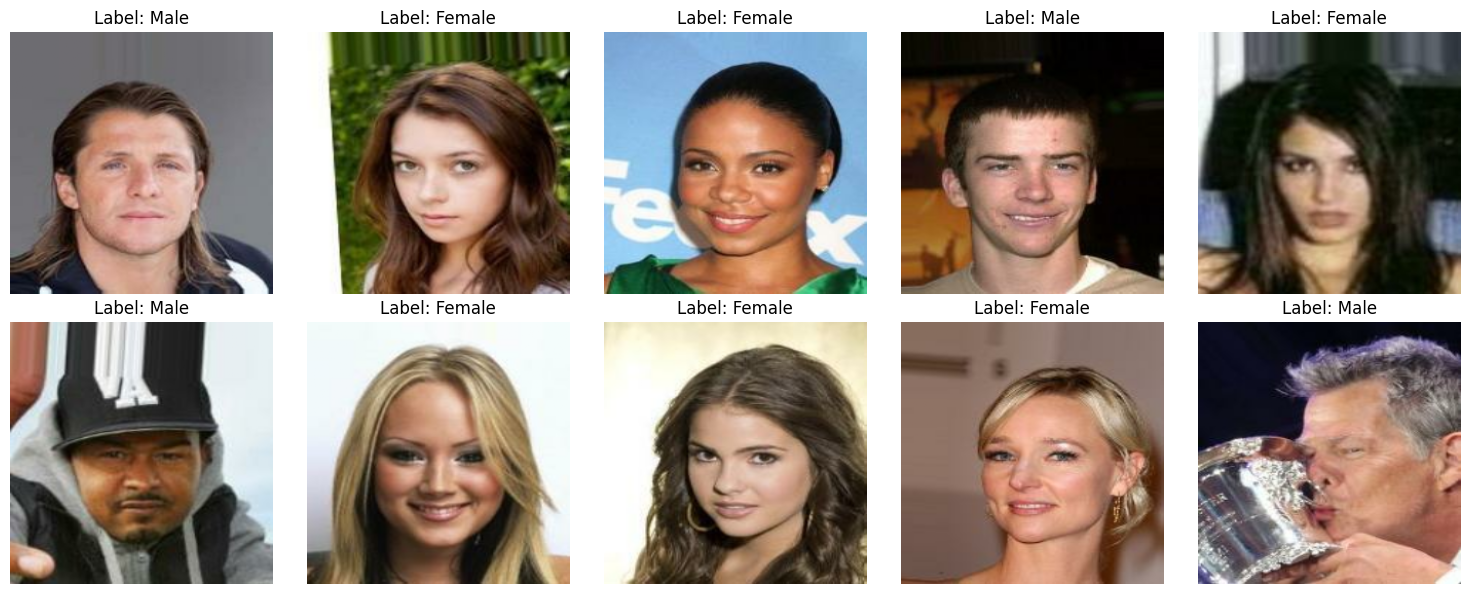

In [ ]:
import matplotlib.pyplot as plt

# Get an iterator for the dataset
train_iter = iter(train_ds)

# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Flatten the 2D axes array into a 1D array
axes = axes.flatten()

# Loop through the first 10 images in the dataset
for i in range(10):
    # Get the next image and label
    image, label = next(train_iter)

    # Plot the image on the corresponding subplot
    axes[i].imshow(image.numpy()/255.0)
    axes[i].set_title(f"Label: {labels[label.numpy()]}")
    axes[i].axis('off')  # Hide the axis

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# **3. Reduce size of image**

In [ ]:
# Function for resizing image
import tensorflow as tf
def preprocess(image, label, size=(64,64),mode='train'):
    if mode == 'train':
        img_crop = tf.image.random_crop(image,size=(178,178,3))
        img_resized = tf.image.resize(img_crop,size=size)
        img_flip = tf.image.random_flip_left_right(img_resized)
        return img_flip/255.0 , tf.cast(label,tf.int32)

    else:
        img_crop = tf.image.crop_to_bounding_box(image,
                                                 offset_height=20,
                                                 offset_width=0,
                                                target_height=178,
                                                target_width=178)
        img_resized = tf.image.resize(img_crop,size=size)
        return img_resized / 255.0 , tf.cast(label,tf.int32)

In [ ]:
# Resize image and create batch
import numpy as np
image_size = (64, 64)
ds_train = train_ds.map(lambda x, y:preprocess(image=x, label=y, size=image_size,mode='train'))
ds_valid = val_ds.map(lambda x, y:preprocess(image=x, label=y, size=image_size,mode='eval'))

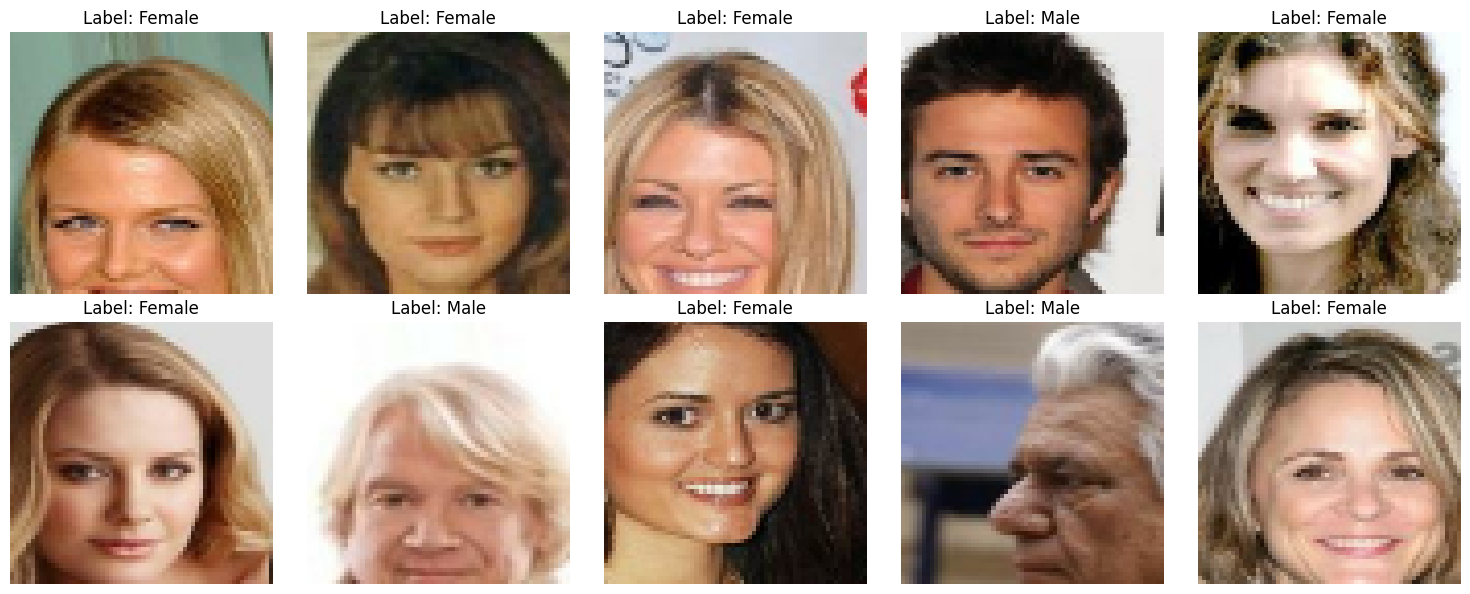

In [ ]:
# Visualize images after resizing
import matplotlib.pyplot as plt

# Get an iterator for the dataset
train_iter = iter(ds_train)

# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Flatten the 2D axes array into a 1D array
axes = axes.flatten()

# Loop through the first 10 images in the dataset
for i in range(10):
    # Get the next image and label
    image, label = next(train_iter)

    # Plot the image on the corresponding subplot
    axes[i].imshow(image.numpy())
    axes[i].set_title(f"Label: {labels[label.numpy()]}")
    axes[i].axis('off')  # Hide the axis

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Buffer size (tampon): TensorFlow loads 160,000 images into memory to shuffle them during each iteration.
# A larger buffer provides better shuffling but uses more memory.
# Reduce the buffer_size if training dosn't work on your device
buffer_size = 10000 # SI CA MARCHE PAS FAUT DIMINUER LA TAILLE DU BUFFER CAR COLLAB PEUT RESTREINDRE LA TAILLE
batch_size = 32

# Shuffle the dataset and create batches
ds_train = ds_train.shuffle(buffer_size=buffer_size).repeat()
ds_train = ds_train.batch(batch_size)
ds_valid = ds_valid.batch(batch_size)

In [ ]:
# Training dataset after resizing
ds_train # Un element n'est plus une image mais un ensemble d'images None = taille du batch

<_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# **4. Create/Train/Save our model**

In [ ]:
import numpy as np
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras import layers, models

# Fonction pour créer le modèle
def create_model():
    inputs = tf.keras.Input(shape=(64, 64, 3))  # Forme d'entrée pour les images RGB 64x64

    # Premier bloc convolutionnel
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Deuxième bloc convolutionnel
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Troisième bloc convolutionnel
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Global Average Pooling au lieu de Flatten
    x = layers.GlobalAveragePooling2D()(x)

    # Couche entièrement connectée
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Couche de sortie pour la classification binaire (2 classes)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Crée le modèle
    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile le modèle
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model



In [ ]:
import tensorflow as tf
steps_per_epoch = int(np.ceil(buffer_size/batch_size))

# Crée et compile le modèle
model = create_model()
model.summary()

# Création du callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraînement avec les poids des classes
class_weights = {0: 1.5, 1: 1.0}  # Pondération des classes

# Entraînement du modèle
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    class_weight=class_weights,
    callbacks=[early_stopping],  # Ajout du callback
)
# Prédiction sur les données de validation après l'entraînement
y_pred = model.predict(ds_valid)
y_pred = np.round(y_pred)  # Arrondir les prédictions à 0 ou 1

# Récupérer les labels réels des données de validation
y_true = np.concatenate([y for x, y in ds_valid], axis=0)

# Calcul du F1-score
f1 = f1_score(y_true, y_pred)
print(f'F1 Score: {f1}')


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_10          │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 405,633 (1.55 MB)

 Trainable params: 404,737 (1.54 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - accuracy: 0.6104 - loss: 0.7294 - val_accuracy: 0.6098 - val_loss: 1.1966
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step - accuracy: 0.7714 - loss: 0.4811 - val_accuracy: 0.6505 - val_loss: 0.6604
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step - accuracy: 0.8729 - loss: 0.2997 - val_accuracy: 0.3980 - val_loss: 1.5052
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step - accuracy: 0.9009 - loss: 0.2358 - val_accuracy: 0.8236 - val_loss: 0.4008
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 104ms/step - accuracy: 0.9177 - loss: 0.1979 - val_accuracy: 0.8250 - val_loss: 0.3443
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - accuracy: 0.9248 - loss: 0.1863 - val_accuracy: 0.8203 - val_loss: 0.3671
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - accuracy: 0.9279 - loss: 0.1739 - val_accuracy: 0.7133 - val_loss: 0.5106
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 111ms/step - accuracy: 0.9311 - loss: 0

# **5. Validate the model**

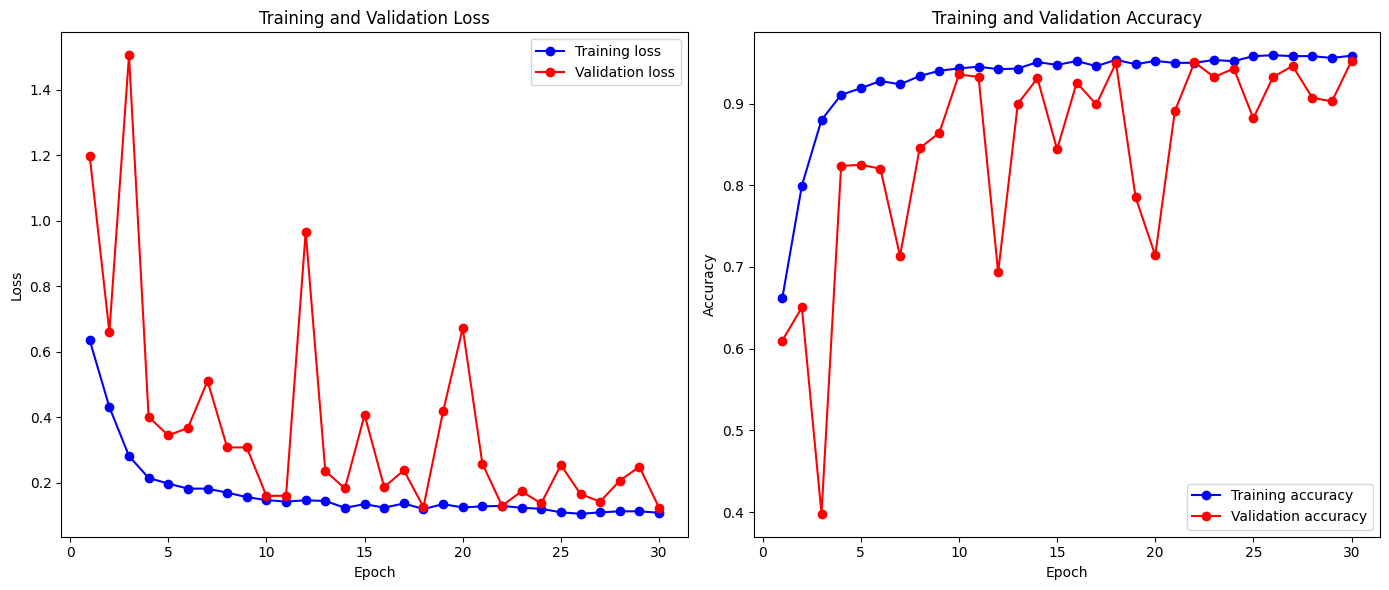

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics from history
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot training & validation loss
ax1.plot(epochs, train_loss, 'bo-', label='Training loss')
ax1.plot(epochs, val_loss, 'ro-', label='Validation loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training & validation accuracy
ax2.plot(epochs, train_accuracy, 'bo-', label='Training accuracy')
ax2.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

In [ ]:
# Create the inference model and load pretrained weights
model_inference = create_model()
model_inference.load_weights("content/drive/myDrive/IA/model_celeba_15_epochs.weights.h5") ##FAUT LE CREER AVEC GRADIO L'INFERENCE

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'content/drive/myDrive/IA/model_celeba_15_epochs.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
ds_test = test_ds.map(lambda x, y: preprocess(x, y, image_size,mode='test')).batch(32)
test_results = model.evaluate(ds_test)
print(f'Test Acc {round(test_results[1]*100,2)}')
# Calculer le F1 score
f1 = f1_score(y_true, y_pred)
print(f'Test F1 Score: {round(f1, 4)}')

626/626 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.9600 - loss: 0.1078
Test Acc 95.95
Test F1 Score: 0.4041


# **6. Inference**

In [ ]:
# Create the inference model and load pretrained weights
model_inference = create_model()
model_inference.load_weights("content/drive/myDrive/IATP/model_celeba_15_epochs.weights.h5") ##FAUT LE CREER AVEC GRADIO L'INFERENCE

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Load an image and predict its class
import tensorflow as tf
def load_image(image_path):
    # Load the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def inference(model, image_path, plot=False):
    # Load and preprocess the image
    image = load_image(image_path)

    # Preprocess for inference (not in 'train' mode)
    preprocessed_image, _ = preprocess(image, label=0, mode='test')

    # Expand dimensions to fit model input
    preprocessed_image = tf.expand_dims(preprocessed_image, axis=0)

    # Make predictions
    predictions = model.predict(preprocessed_image)

    # Convert predictions to class labels
    predicted_class = "Female" if predictions[0][0] < 0.5 else "Male"
    confidence = predictions[0][0] if predictions[0][0] >= 0.5 else 1 - predictions[0][0]
    if plot == False:
      # Print the results
      print(f'Predicted class: {predicted_class}')
      print(f'Confidence: {confidence:.4f}')

    else:
      # Display the original image
      plt.figure(figsize=(8, 8))
      plt.imshow(tf.cast(image, tf.uint8))  # Cast back to uint8 for proper display
      plt.title(f'Predicted class: {predicted_class} ({confidence:.2f})')
      plt.axis('off')
      plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


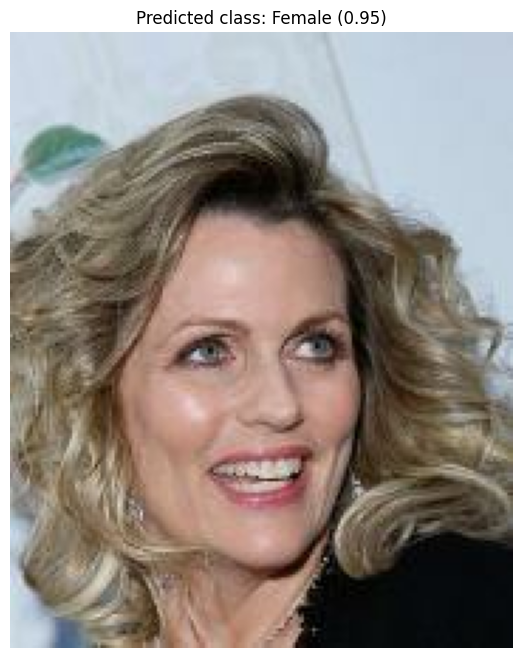

In [ ]:
# Prediction 1
image_path = "/content/celebrities/Dataset/Test/Female/160009.jpg"
inference(model_inference, image_path, plot=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


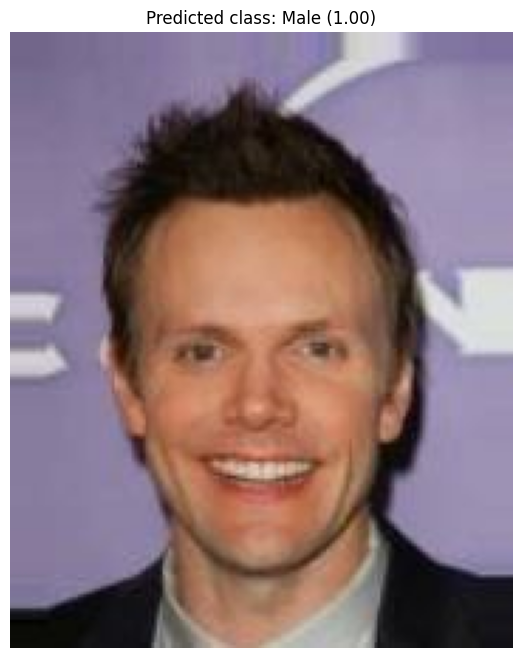

In [ ]:
# Prediction 2
image_path = "/content/celebrities/Dataset/Test/Male/160038.jpg"
inference(model_inference, image_path, plot=True)